### 꽃 이미지 분류 및 예측 예제(CNN)

In [1]:
# flower_photo 디렉토리 밑에 daisy, dendelion, roses, sunflowers, tulips 디렉토리 존재, 약 4670개 사진
import matplotlib.pyplot as plt
import numpy as np
import PIL
import tensorflow as tf
from tensorflow.keras import layers
import os
import pathlib
import urllib.request
import tarfile

In [18]:
# 데이터 다운로드 함수
def download_and_extract_data():
    # 데이터 URL
    dataset_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"

    # 다운로드할 디렉토리 생성
    download_dir = os.path.join(os.getcwd(), 'flower_dataset')
    os.makedirs(download_dir, exist_ok=True)

    # 파일 다운로드
    tgz_path = os.path.join(download_dir, "flower_photos.tgz")

    if not os.path.exists(tgz_path):
        print("데이터셋 다운로드 중...")
        urllib.request.urlretrieve(dataset_url, tgz_path)
        print("다운로드 완료!")

    # 압축 해제
    if not os.path.exists(os.path.join(download_dir, "flower_photos")):
        print("압축 해제 중...")
        with tarfile.open(tgz_path) as tar:
            tar.extractall(path=download_dir)
        print("압축 해제 완료!")

    return os.path.join(download_dir, "flower_photos")

In [19]:
# 데이터 다운로드 및 경로 설정
data_dir = download_and_extract_data()
data_dir = pathlib.Path(data_dir)

데이터셋 다운로드 중...
다운로드 완료!
압축 해제 중...
압축 해제 완료!


In [20]:
# 클래스 및 이미지 개수 확인
classes = sorted([item.name for item in data_dir.glob('*/') if item.is_dir()])
image_count = len(list(data_dir.glob('*/*.jpg')))
print(f"발견된 클래스: {classes}")
print(f"총 이미지 개수: {image_count}")

발견된 클래스: ['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']
총 이미지 개수: 3670


In [21]:
# 각 클래스별 이미지 개수 확인
for class_name in classes:
    class_images = len(list(data_dir.glob(f'{class_name}/*')))
    print(f"{class_name}: {class_images}개 이미지")

daisy: 633개 이미지
dandelion: 898개 이미지
roses: 641개 이미지
sunflowers: 699개 이미지
tulips: 799개 이미지


In [44]:
# 이미지 크기 및 배치 크기 설정
img_height = 180
img_width = 180
batch_size = 16

In [23]:
# 훈련 데이터셋 생성
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    str(data_dir),
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size
)

Found 3670 files belonging to 5 classes.
Using 2936 files for training.


In [24]:
# 검증 데이터셋 생성
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    str(data_dir),
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size
)

Found 3670 files belonging to 5 classes.
Using 734 files for validation.


In [25]:
# 클래스 이름 확인
class_names = train_ds.class_names
print("클래스:", class_names)
num_classes = len(class_names)

클래스: ['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']


In [26]:
# 데이터셋 성능 최적화
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [27]:
# 데이터 증강 레이어 정의
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.2),
    layers.RandomZoom(0.2),
])

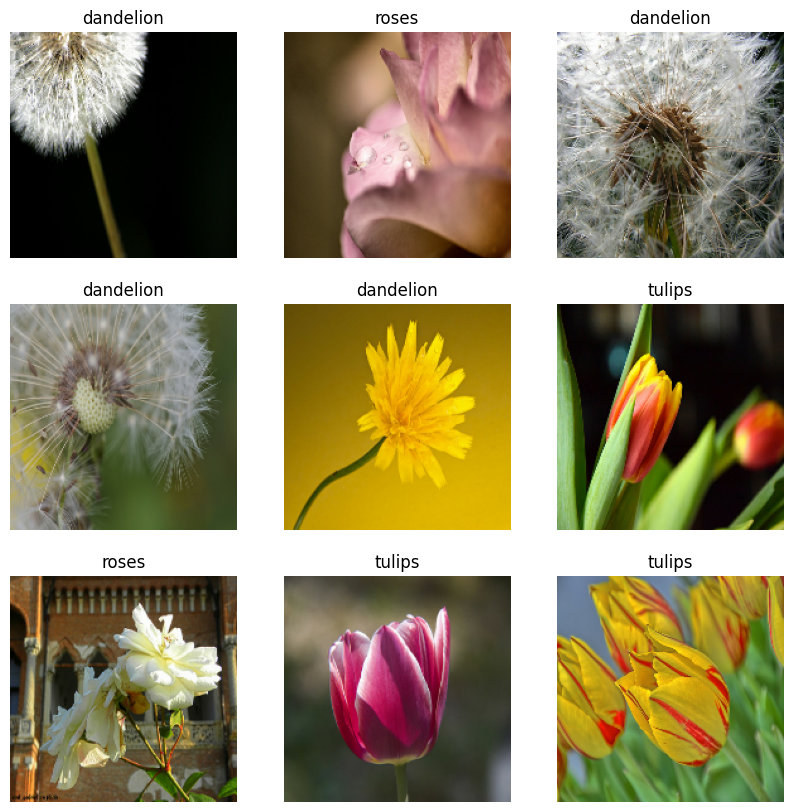

In [28]:
# 샘플 이미지 시각화
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")
plt.show()

In [31]:
# CNN 모델 구성
model = tf.keras.Sequential([
    data_augmentation,
    layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
    layers.Conv2D(16, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(32, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(64, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Dropout(0.2),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(num_classes, activation='softmax')
    ])

c:\ai_files\dl_Study\.venv\lib\site-packages\keras\src\layers\preprocessing\tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [32]:
# 모델 컴파일
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),  # 다중클래스에서 주로 사용, 각 클래스별 확률 예측 및 손실계산
    metrics=['accuracy']
)

In [33]:
# Early Stopping 콜백 설정
callbacks = [
    tf.keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=3,
        restore_best_weights=True
    )
]

In [45]:
# 모델 학습
epochs = 30
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs,
    callbacks=callbacks
)

Epoch 1/30
92/92 ━━━━━━━━━━━━━━━━━━━━ 22s 238ms/step - accuracy: 0.7490 - loss: 0.6771 - val_accuracy: 0.7193 - val_loss: 0.7165
Epoch 2/30
92/92 ━━━━━━━━━━━━━━━━━━━━ 21s 228ms/step - accuracy: 0.7440 - loss: 0.6711 - val_accuracy: 0.7166 - val_loss: 0.7304
Epoch 3/30
92/92 ━━━━━━━━━━━━━━━━━━━━ 21s 226ms/step - accuracy: 0.7465 - loss: 0.6498 - val_accuracy: 0.7343 - val_loss: 0.6986
Epoch 4/30
92/92 ━━━━━━━━━━━━━━━━━━━━ 21s 227ms/step - accuracy: 0.7598 - loss: 0.6185 - val_accuracy: 0.7343 - val_loss: 0.7214
Epoch 5/30
92/92 ━━━━━━━━━━━━━━━━━━━━ 21s 229ms/step - accuracy: 0.7603 - loss: 0.6070 - val_accuracy: 0.7357 - val_loss: 0.6945
Epoch 6/30
92/92 ━━━━━━━━━━━━━━━━━━━━ 20s 221ms/step - accuracy: 0.7707 - loss: 0.5921 - val_accuracy: 0.7371 - val_loss: 0.7189
Epoch 7/30
92/92 ━━━━━━━━━━━━━━━━━━━━ 20s 221ms/step - accuracy: 0.7856 - loss: 0.5591 - val_accuracy: 0.7302 - val_loss: 0.6937
Epoch 8/30
92/92 ━━━━━━━━━━━━━━━━━━━━ 20s 221ms/step - accuracy: 0.7599 - loss: 0.6202 - val_accu

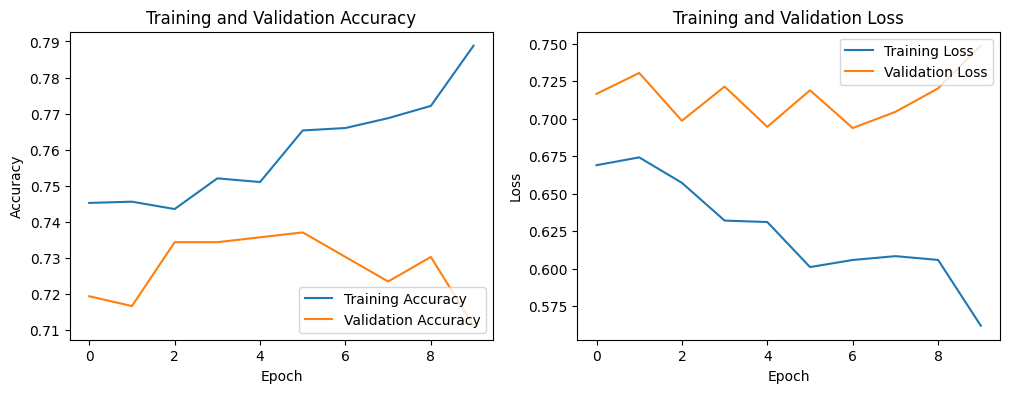

In [46]:

# 학습 결과 시각화
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(len(acc))

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.show()

In [47]:
# 모델 저장
model.save('./model/flower_classification_model.h5')
print("모델이 'flower_classification_model.h5'로 저장되었습니다.")

모델이 'flower_classification_model.h5'로 저장되었습니다.


In [48]:
# 저장된 모델 불러오기
from tensorflow.keras.models import load_model

In [49]:
model_path = './model/flower_classification_model.h5'  # 저장된 모델 경로
loaded_model = load_model(model_path)
print("저장된 모델이 성공적으로 로드되었습니다.")

저장된 모델이 성공적으로 로드되었습니다.


In [50]:
# 저장된 모델을 활용한 이미지 예측 함수
def predict_flower_with_loaded_model(img_path, model, class_names):
    """
    이미지 경로와 모델을 입력받아 예측 결과를 출력하고 이미지를 시각화하는 함수.

    Parameters:
        img_path (str): 예측할 이미지 파일 경로.
        model (tf.keras.Model): 저장된 모델.
        class_names (list): 클래스 이름 리스트.
    """
    # 이미지 로드 및 전처리
    img = tf.keras.preprocessing.image.load_img(
        img_path, target_size=(img_height, img_width)
    )
    img_array = tf.keras.preprocessing.image.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0)  # 배치 차원 추가

    # 예측 수행
    predictions = model.predict(img_array)
    score = tf.nn.softmax(predictions[0])

    # 예측 결과 출력
    print(
        "이 이미지는 '{}' ({:.2f}% 확률) 입니다."
        .format(class_names[np.argmax(score)], 100 * np.max(score))
    )

    # 이미지 시각화
    plt.imshow(img)
    plt.axis('off')
    plt.show()


In [53]:
# 테스트 이미지 경로
# test_image_path = './flower_dataset/flower_photos/daisy/5547758_eea9edfd54_n.jpg'

test_image_path = './flower_dataset/flower_photos/roses/12240303_80d87f77a3_n.jpg'

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
이 이미지는 'roses' (28.16% 확률) 입니다.


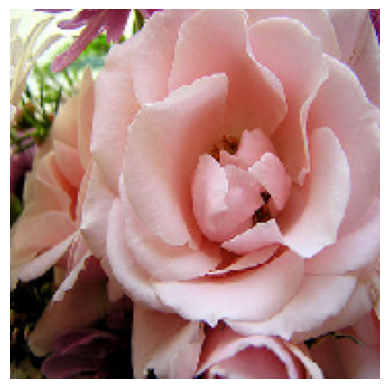

In [54]:
# 예측 실행
predict_flower_with_loaded_model(test_image_path, loaded_model, class_names)